In [1]:
# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import time

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np
from itertools import combinations
from enum import Enum

In [4]:
from urdf_parser_py.urdf import URDF
from pkg.ur10 import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE
from pkg.joint_utils import *
from pkg.ros_rviz import *

In [5]:
from pkg.tf_transform import *
from pkg.tf_robot import *
from pkg.constraint import *
from pkg.info import *
from pkg.tf_utils import *
from pkg.rotation_utils import *
from pkg.utils import *
from pkg.ur10 import *
from pkg.geometry import *
from pkg.collision import *
from pkg.distance import *
from pkg.distance_calculator import *
from pkg.binding_calculator import *
from pkg.graph_tf import *

In [6]:
from queue import PriorityQueue

# Data types

In [7]:
class Scenario(Enum):
    single_object_single_robot = 0
    double_object_single_robot = 1
    single_object_dual_robot = 2
    assembly_3_piece = 3

class State(CompareInterface):
    def __init__(self, node, obj_pos_dict, Q):
        self.node = node
        self.obj_pos_dict = obj_pos_dict
        self.Q = Q
    
    def get_tuple(self):
        return (self.node, self.obj_pos_dict, self.Q)
    
    def copy(self):
        return State(self.node, self.obj_pos_dict, self.Q)
        
    def __str__(self):
        return str((self.node, 
                    {k: str(np.round(v, 2)) for k, v in self.obj_pos_dict.items()} if self.obj_pos_dict is not None else None,  
                    str(np.round(self.Q, 2)) if self.Q is not None else None))
    
class SearchNode(CompareInterface):
    def __init__(self, idx, state, parents, leafs, leafs_P, depth=None, edepth=None):
        self.idx, self.state, self.parents, self.leafs, self.leafs_P, self.depth, self.edepth = \
            idx, state, parents, leafs, leafs_P, depth, edepth

# Constraint Graph

In [8]:

        
class ConstraintGraph:
    DEFAULT_TRANSIT_COST = 1.0
    WEIGHT_DEFAULT = 2.0
    DQ_MAX = np.deg2rad(90)
    DSCALE = 1e4

    def __init__(self, urdf_path,  joint_names, link_names):
        self.urdf_path = urdf_path
        self.urdf_content = URDF.from_xml_file(urdf_path)
        self.link_info_list = get_link_info_list(link_names, self.urdf_content)
        self.robot_info = RobotInfo(self.link_info_list, rname = "rbt0", base_frame=np.identity(4,dtype=np.float32))
        self.joint_names = joint_names
        self.link_names = link_names
        
    def set_items(self, gitem_list, gframe_dict):
        self.gitem_list = gitem_list
        self.gframe_dict = gframe_dict
        
        # prepare ros
        self.pub, self.joints, self.rate_ros = get_publisher(self.joint_names)
        # prepare visualization markers
        self.marker_list = set_markers(self.gitem_list, self.gframe_dict, self.urdf_content)
        show_motion([np.array([0]*6)], self.marker_list, 
                    [[gframe_dict[mk.geometry.name] for mk in self.marker_list]], 
                    self.pub, self.joints, error_skip=1e-6, period=1e-6)
        
    def show_state(self, gframe_dict=None):
        if gframe_dict is not None:
            self.gframe_dict = gframe_dict
        show_motion([np.array([0]*6)], self.marker_list, 
                    [[gframe_dict[mk.geometry.name] for mk in self.marker_list]], 
                    self.pub, self.joints, error_skip=1e-6, period=1e-6)
        
    def set_binding(self, binfo_list):
        self.binfo_list = binfo_list
        
    def set_simulation(self, N_sim, binfo_list=None, **kwargs):
        self.N_sim = N_sim
        if binfo_list is not None:
            self.set_binding(binfo_list)
        self.model = GraphModel(robot_info=self.robot_info, gitem_list=self.gitem_list, binfo_list=self.binfo_list, 
                           urdf_content=self.urdf_content, N_sim=self.N_sim, **kwargs)
        
    def update_handles(self):
        self.handle_dict = defaultdict(lambda: [])
        for k, v in self.model.binding_dict.items():
            if not v.btype.is_binder():
                self.handle_dict[v.obj_layer.name] += [k]
        self.object_list = [name for name in self.model.object_name_list if name in self.handle_dict]
        self.binder_list = [name for name in self.model.binding_name_list if self.model.binding_dict[name].btype.is_binder()]
        

    def get_unique_binders(self):
        uniq_binders = []
        for k_b, binder in self.model.binding_dict.items():
            if binder.btype.is_binder() and not binder.btype.is_multiple():
                uniq_binders += [k_b]
        return uniq_binders

    def get_controlled_binders(self):
        controlled_binders = []
        for k_b, binder in self.model.binding_dict.items():
            if binder.btype.is_binder() and binder.btype.is_controlled():
                controlled_binders += [k_b]
        return controlled_binders
    
    def build_graph(self):
        self.update_handles()
        self.node_dict = {}
        bindings = get_all_mapping(self.handle_dict.keys(), self.binder_list)
        handle_combinations = list(product(*[self.handle_dict[obj] for obj in self.object_list]))
        uniq_binders = self.get_unique_binders()
        ctrl_binders = self.get_controlled_binders()
        self.node_list = []
        self.node_dict = {}
        for binding in bindings:
            if all([np.sum([bd == ub for bd in  binding.values()])<=1 for ub in uniq_binders]):
                for hc in handle_combinations:
                    node = []
                    add_ok = True
                    for i_o, obj in zip(range(len(self.object_list)), self.object_list):
                        hndl_name = hc[i_o]
                        if self.model.bind_cal.pair_condition(self.model.binding_dict[binding[obj]], self.model.binding_dict[hndl_name]):
                            node += [(obj, hc[i_o], binding[obj]) ]
                        else:
                            add_ok = False
                    if add_ok:
                        node = tuple(node)
                        self.node_list += [node]
                        self.node_dict[node] = []
        for node in self.node_list:
            fixed_in = [i_n for i_n in range(len(node)) if node[i_n][2] not in ctrl_binders]
            ctrl_in = [i_n for i_n in range(len(node)) if node[i_n][2] in ctrl_binders]
            if ctrl_in:
                bd_fixed = [node[idx] for idx in fixed_in]
                bd_ctrl = [node[idx][2] for idx in ctrl_in]
                pt_ctrl = [node[idx][1] for idx in ctrl_in]
                obj_ctrl = [node[idx][0] for idx in ctrl_in]
                nodes_same_fix = [nd for nd in  self.node_list if [nd[idx] for idx in fixed_in] == bd_fixed]
                nodes_diff_ctrl = [nd for nd in  nodes_same_fix if [nd[idx][2] for idx in ctrl_in] != bd_ctrl]
                nodes_diff_pt = [nd for nd in  nodes_diff_ctrl if [nd[idx][1] for idx in ctrl_in] != pt_ctrl]
                nodes_neighbor = [nd for nd in  nodes_diff_pt if len(set([bd[2] for bd, bd0 in zip(nd, node) if bd!=bd0]).intersection(bd_ctrl))==0]
                self.node_dict[node] += nodes_neighbor
                for nd_n in nodes_neighbor:
                    self.node_dict[nd_n] += [node]

        for node in self.node_dict.keys():
            if node in self.node_dict[node]:
                self.node_dict[node].remove(node)
            self.node_dict[node] = [node] + list(set(self.node_dict[node]))
        
    def score_graph(self, goal_node):
        frontier = PriorityQueue()
        frontier.put(goal_node, 0)
        came_from = {}
        node_cost_dict = {}
        came_from[goal_node] = None
        node_cost_dict[goal_node] = 0

        while not frontier.empty():
            current = frontier.get()

            for next in self.node_dict[current]:
                if next == current:
                    continue
                new_cost = node_cost_dict[current] + ConstraintGraph.DEFAULT_TRANSIT_COST
                if next not in node_cost_dict or new_cost < node_cost_dict[next]:
                    node_cost_dict[next] = new_cost
                    priority = new_cost
                    frontier.put(next, priority)
                    came_from[next] = current
        return node_cost_dict
                  
    def check_goal(self, state, goal):
        return all([g is None or s==g for s,g in zip(state.get_tuple(), goal.get_tuple())])
    
    def get_valid_neighbor(self, node, margin=0):
        neighbor = self.node_dict[node]
        neighbor_valid = []
        for leaf in neighbor:
            if self.goal_cost_dict[leaf]<=self.goal_cost_dict[node]+margin:
                neighbor_valid += [leaf]
        return neighbor_valid

    def reset_valid_node(self, margin=0, node=None):
        if node == None:
            node = self.initial_state.node
            self.valid_node_dict = {self.goal_state.node:[]}
        if node == self.goal_state.node or node in self.valid_node_dict:
            return
        neighbor = self.get_valid_neighbor(node, margin=margin)
        if node in self.valid_node_dict and self.valid_node_dict[node] == neighbor:
            return
        self.valid_node_dict[node] = neighbor
        for leaf in neighbor:
            new_margin = margin - max(0, self.goal_cost_dict[leaf]-self.goal_cost_dict[node])
            new_margin = max(0, new_margin)
            if leaf != node and new_margin>=0:
                self.reset_valid_node(margin=new_margin, node=leaf)
    def get_link(self, oname, new_binding_dict, gframe_base):
        bindee_name = new_binding_dict[oname][0]
        binder_name = new_binding_dict[oname][1]
        bobj_name = self.model.binding_dict[binder_name].obj_layer.name
        if bobj_name in gframe_base:
            return gframe_base[bobj_name].link_name
        else:
            return self.get_link(bobj_name, new_binding_dict, gframe_base)

    def State2FrameDict(self, state):
        new_binding_dict = {bd[0]: (bd[1], bd[2]) for bd in state.node}
        gframe_base = {k:v for k, v in self.gframe_dict.items() if k not in new_binding_dict}
        new_gframe_dict = dict(self.gframe_dict)
        for oname in list(new_binding_dict.keys()):
            opos = state.obj_pos_dict[oname]
            oToff = SE3(Rotation.from_quat(opos[3:]).as_matrix(), opos[:3])
            obj_link = self.get_link(oname, new_binding_dict, gframe_base)
            new_gframe_dict[oname] = GeometryFrame(oToff, obj_link)
        return new_gframe_dict

    def FrameDict2State(self, gframe_dict, Q, state_ref):
        obj_pos_dict_new = {}
        for k in state_ref.obj_pos_dict.keys():
            Toff = gframe_dict[k].Toff
            Poff = Toff[:3, 3]
            Quat = Rotation.from_matrix(Toff[:3,:3]).as_quat()
            pos = np.concatenate([Poff, Quat], axis=-1)
            obj_pos_dict_new[k] = pos
        return State(state_ref.node, obj_pos_dict_new, Q)
    
    def get_slack_pairs(self, state, to_state):
        done = False
        slacks = []
        for bd, to_bd in zip(state.node, to_state.node):
            if bd != to_bd:
                slacks += [tuple(self.model.binding_index_dict[bname] for bname in to_bd[1:])]
                done = True
        Q = np.zeros((self.model.robot.DOF,), dtype=np.float32)
        Qmask = np.zeros((self.model.robot.DOF,), dtype=np.float32)
        if not done:
            Q = to_state.Q
            Qmask = np.ones((self.model.robot.DOF,), dtype=np.float32)
        return slacks, Q, Qmask
    
    def simulate_transition_batch(self, from_state_list, to_state_list, display=False, display_duration=1e-2, N_loop=100):
    #     gtimer.reset()
    #     gtimer.tic("convert")
        # convert
        gframe_dict_list = []
        Q_list = []
        Qtar_list = []
        Qmask_list = []
        slack_batch = []
        for state, to_state in zip(from_state_list, to_state_list):
            gframe_dict_list += [self.State2FrameDict(state)]
            Q_list += [state.Q]
            slacks, Qtar, Qmask = self.get_slack_pairs(state, to_state)
            slack_batch += [slacks]
            Qtar_list += [Qtar]
            Qmask_list += [Qmask]
        # fill rest
        N_rest = (self.model.N_sim-len(from_state_list))
        gframe_dict_list += [gframe_dict_list[-1]]*N_rest
        Q_list += [Q_list[-1]]*N_rest
        slack_batch += [slack_batch[-1]]*N_rest
        Qtar_list += [Qtar_list[-1]]*N_rest
        Qmask_list += [Qmask_list[-1]]*N_rest
        Q_mat = np.array(Q_list, dtype=np.float32)
        joint_batch = np.array(Qtar_list, dtype=np.float32)
        joint_mask_batch = np.array(Qmask_list, dtype=np.float32)
    #     gtimer.toc("convert")

    #     gtimer.tic("assign")
        self.model.assign_Q(Q_mat)
        self.model.assign_frame_dict(gframe_dict_list)
        self.model.set_slack_batch(slack_batch, joint_batch, joint_mask_batch)
    #     gtimer.toc("assign")

    #     gtimer.tic("step")
        if display:
            res, T_all, Tbo_all = self.model.run_test_disp(N_loop=N_loop, show_motion_func=self.show_motion, idx_show=0)
            timer.sleep(display_duration)
        else:
            res, T_all, Tbo_all = self.model.run_test(N_loop=N_loop)
    #     gtimer.toc("step")

    #     gtimer.tic("revert")
        Qnew = self.model.get_Q().numpy()
        res = res.numpy()
        gframe_dict_list_new = self.model.update_slack_frames(gframe_dict_list, T_all, Tbo_all)
        new_state_list = []
        for i_s, gframe_dict, to_state in zip(range(self.model.N_sim), gframe_dict_list_new, to_state_list):
            new_state_list += [self.FrameDict2State(gframe_dict, Qnew[i_s], to_state)]
    #     gtimer.toc("revert")

        return new_state_list, res
    
    def show_motion(self, pose, gframeset):
        gframevec = [gframeset[mk.geometry.name] for mk in self.marker_list]
        gframevec_list = [gframevec]
        show_motion([pose], self.marker_list, gframevec_list, 
                    self.pub, self.joints, error_skip=1e-6, period=1e-6)
        
        

    def add_node_queue_leafs(self, snode):
        snode.idx = self.snode_counter
        self.snode_vec += [snode]
        self.snode_counter += 1
        state = snode.state
        leafs = self.valid_node_dict[state.node]
        if len(leafs) == 0:
            return snode
        leafs = leafs[:-1]+[leafs[-1]]*self.joint_motion_num
        for leaf in leafs:
            depth = len(snode.parents)+1
            expected_depth = depth+self.goal_cost_dict[leaf]
            if expected_depth>self.depth_max:
                continue
            to_state = state.copy()

            if leaf == state.node:
                dQ = (1-2*np.random.rand(self.DOF))*ConstraintGraph.DQ_MAX
                to_state.Q = np.sum([state.Q, dQ], axis=0)
            else:
                to_state.node = leaf
            self.snode_queue.put((expected_depth*self.DSCALE-depth, snode, state, to_state))
        return snode

    def search_graph(self, initial_state, goal_state, display=False, 
                 terminate_on_first = True, tree_margin = 0, depth_margin = 0, joint_motion_num=10, 
                 N_search = 100, verbose = False, N_loop=100):
        self.joint_motion_num = joint_motion_num
        self.t0 = timer.time()
        self.DOF = len(initial_state.Q)
        self.initial_state = initial_state
        self.goal_state = goal_state

        self.init_cost_dict, self.goal_cost_dict = self.score_graph(initial_state.node), self.score_graph(goal_state.node)
        self.reset_valid_node(tree_margin)
        depth_min = self.goal_cost_dict[initial_state.node]
        self.depth_max = depth_min + depth_margin

        for k in self.valid_node_dict.keys():
            self.valid_node_dict[k].reverse()
        self.snode_counter = 0
        self.snode_vec = []
        self.snode_queue = PriorityQueue()
        self.add_node_queue_leafs(SearchNode(idx=0, state=initial_state, parents=[], leafs=[], 
                       leafs_P=[ConstraintGraph.WEIGHT_DEFAULT]*len(self.valid_node_dict[initial_state.node])))
        while self.snode_counter<N_search:
            snode_list = []
            from_state_list = []
            to_state_list = []
            for _ in range(self.model.N_sim):
                if self.snode_queue.empty():
                    break
                else:
                    snode, from_state, to_state = self.snode_queue.get()[1:]
                    snode_list += [snode]
                    from_state_list += [from_state]
                    to_state_list += [to_state]
            N_sim_cur = len(snode_list)
            new_state_list, res = self.simulate_transition_batch(from_state_list, to_state_list, display=display, N_loop=N_loop)
            ret = False
            for i_s in range(N_sim_cur):
                succ = res[i_s]
                state = from_state_list[i_s]
                to_state = to_state_list[i_s]
                snode = snode_list[i_s]
                new_state = new_state_list[i_s]
                if succ:
                    snode_new = SearchNode(idx=len(self.snode_vec), state=new_state, parents=snode.parents+[snode.idx], leafs=[], 
                                   leafs_P=[])
                    snode_new = self.add_node_queue_leafs(snode_new)
                    snode.leafs += [snode_new.idx]
                    self.snode_vec[snode.idx] = snode
                    if self.check_goal(snode_new.state, self.goal_state):
                        ret = True
                if verbose:
                    print('\n{} - Goal cost:{}->{} / Init cost:{}->{} / branching: {}->{} ({} s)'.format(
                        "success" if succ else "fail",
                        int(self.goal_cost_dict[state.node]), int(self.goal_cost_dict[to_state.node]),
                        int(self.init_cost_dict[state.node]), int(self.init_cost_dict[to_state.node]),  
                        snode.idx, snode_new.idx if succ else "", round(timer.time()-self.t0,2)))
                    print('node: {}->{}'.format(state.node, to_state.node))
                    print('='*150)
            if terminate_on_first and ret:
                break
    
    def print_snode_list(self):
        for i_s, snode in zip(range(len(self.snode_vec)),self.snode_vec):
            print("{}{}<-{}{}".format(i_s, snode.state.node, snode.parents[-1] if snode.parents else "", self.snode_vec[snode.parents[-1]].state.node if snode.parents else ""))

    def quiver_snodes(self, figsize=(10,10)):
        import matplotlib.pyplot as plt
        N_plot = len(self.snode_vec)
        cost_vec = [self.goal_cost_dict[snode.state.node] for snode in self.snode_vec[1:N_plot]]
        parent_vec = [self.goal_cost_dict[self.snode_vec[snode.parents[-1]].state.node] for snode in self.snode_vec[1:N_plot]]
        plt.figure(figsize=figsize)
        X = list(range(1,N_plot))
        plt.quiver(X, parent_vec, 
                   [0]*(N_plot-1), 
                   np.subtract(cost_vec, parent_vec), 
                   angles='xy', scale_units='xy', scale=1)
        plt.plot(X, cost_vec,'.')
        plt.plot(X, parent_vec,'.')
        plt.axis([0,N_plot+1,-0.5,4.5])
        
    def find_schedules(self):
        self.idx_goal = []
        schedule_dict = {}
        for i in range(len(self.snode_vec)):
            snode = self.snode_vec[i]
            state = snode.state
            if self.check_goal(state, self.goal_state):
                self.idx_goal += [i]
                schedule = snode.parents + [i]
                schedule_dict[i] = schedule
        return schedule_dict

    def sort_schedule(self, schedule_dict):
        return sorted(schedule_dict.values(), key=lambda x: len(x))

    def replay(self, schedule, duration=1e-2, N_loop=100):
        for i_s in range(1, len(schedule)):
            self.simulate_transition_batch([self.snode_vec[schedule[i_s-1]].state], 
                                           [self.snode_vec[schedule[i_s]].state], 
                                           display=True,display_duration=duration, N_loop=N_loop)

# Test

In [9]:
cgraph = ConstraintGraph(urdf_path = URDF_PATH, joint_names = JOINT_NAMES, link_names = LINK_NAMES)
gtimer = GlobalTimer()

In [10]:
gitem_list, gframe_dict= get_link_items_offsets(color=(0,1,0,0.5), display=False)
gitem_list += [
    GeometryItem(name='box1', gtype=GeoType.BOX, dims=[0.1,0.1,0.1], color=(0.3,0.3,0.8,1), display=True, collision=True),
    GeometryItem(name='floor', gtype=GeoType.PLANE, dims=[3,3,0.01], color=(0.6,0.6,0.6,1), display=True, collision=True),
    GeometryItem(name='wall', gtype=GeoType.BOX, dims=[0.7,0.05,0.2], color=(0.4,0.3,0.0,1), display=True, collision=True),
    GeometryItem(name='stepper', gtype=GeoType.BOX, dims=[0.15,0.15,0.3], color=(0.4,0.3,0.0,1), display=True, collision=True),
    GeometryItem(name='goal_disp', gtype=GeoType.BOX, dims=[0.1,0.1,1e-3], color=(0.8,0.0,0.0,1), display=True, collision=False)
]
gframe_dict.update({"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,-0.2,0.050)), "world"),
                    "floor":GeometryFrame(SE3(Rot_zyx(0,0,0),(0,0,-0.00501)), "world"),
                    "wall":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.7,0.0,0.1)), "world"),
                    "stepper":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.4,0.4,0.15)), "world"),
                    "goal_disp":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.4,0.4,0.3)), "world")
                   })
binfo_list = [
    BindingInfo(
        name='vac1', btype=BindingType.VACC, obj_name='tool_mesh', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,0), (0,0,0.05))), 
    BindingInfo(
        name='goal', btype=BindingType.PLANE, obj_name='stepper', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,np.pi), (0,0,0.151))), 
    BindingInfo(
        name='floortop', btype=BindingType.PLANE, obj_name='floor', gtype=None, Toff=SE3(Rot_zyx(0,0,np.pi), (0,0,0.005)))]

binfo_list +=  get_box_binding(get_by_name(gitem_list, "box1"))

In [11]:
cgraph.set_items(gitem_list, gframe_dict)
cgraph.set_binding(binfo_list)
cgraph.show_state(gframe_dict)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
publication OK - tool_mesh
publication OK - box1
publication OK - floor
publication OK - wall
publication OK - stepper
publication OK - goal_disp


In [12]:
cgraph.set_simulation(N_sim=32, dQ_max = tf.constant([[1.0]*6])*1e-1, COL_AVOID_MULTIPLIER=1)

In [13]:
cgraph.build_graph()
# for k,v in cgraph.node_dict.items():
#     print(k)
#     print(v)
#     print("="*100)

# Dev search graph

In [14]:
ZERO_JOINT_POSE = np.array([-1, -np.pi*0.6 , np.pi*0.6,-np.pi/2,-np.pi/2,0])

In [15]:
gtimer.reset()
gtimer.tic("search")
cgraph.search_graph(initial_state=State((('box1','box1-bottom','floortop'),), {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE), 
             goal_state=State((('box1','box1-bottom','goal'),), None, None), display=False, 
                 terminate_on_first=True, tree_margin=0, depth_margin=2, joint_motion_num=10, 
                 N_search = 100, verbose = True, N_loop=100)
gtimer.toc("search")
print(gtimer)


success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (17.02 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-top', 'vac1'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->2 (17.02 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-bottom', 'floortop'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->3 (17.03 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-bottom', 'floortop'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->4 (17.04 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-bottom', 'floortop'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->5 (17.04 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-bottom', 'floortop'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->6 (17.05 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-bottom', 'floortop'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->7 (17.06 s)



fail - Goal cost:1->0 / Init cost:1->2 / branching: 18-> (20.06 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 11-> (20.06 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 15-> (20.06 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 14-> (20.06 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 16-> (20.06 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 12-> (20.06 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 13-> (20.06 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

fail 


success - Goal cost:1->0 / Init cost:1->2 / branching: 36->41 (21.49 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 35-> (21.49 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

success - Goal cost:1->0 / Init cost:1->2 / branching: 39->42 (21.49 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

success - Goal cost:1->0 / Init cost:1->2 / branching: 38->43 (21.49 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 37-> (21.49 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

success - Goal cost:1->0 / Init cost:1->2 / branching: 40->44 (21.49 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-bottom', 'goal'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 32-> (21.49 s)
node: (('box1', 'box1-top', 'vac1'),)->(('box1', 'box1-botto

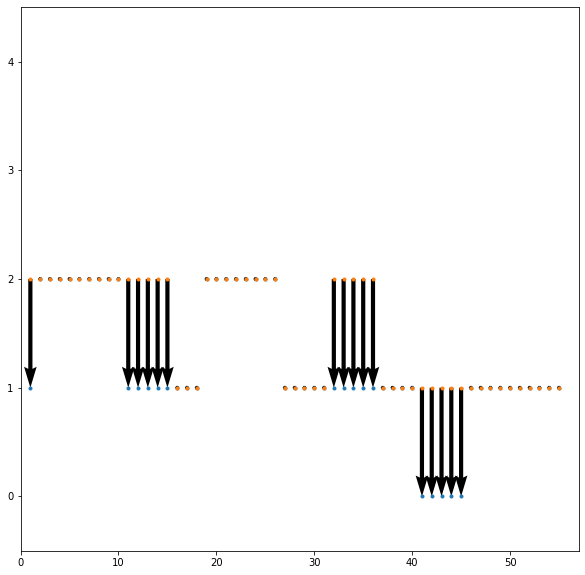

In [16]:
cgraph.quiver_snodes()
# cgraph.print_snode_list()

In [17]:
schedule_dict = cgraph.find_schedules()
schedule_sorted = cgraph.sort_schedule(schedule_dict)
for schedule in schedule_sorted:
    print(schedule)
    cgraph.replay(schedule,0.1, N_loop=100)

[0, 4, 26, 36, 41]
[0, 4, 11, 39, 42]
[0, 4, 11, 38, 43]
[0, 4, 11, 40, 44]
[0, 1, 18, 27, 45]


# Debug collision

In [18]:
self = cgraph
#def search_graph(self, initial_state, goal_state, display=False, 
#         terminate_on_first = True, tree_margin = 0, depth_margin = 0, joint_motion_num=10, 
#         N_search = 100, verbose = False, N_loop=100):
initial_state=State((('box1','box1-bottom','floortop'),), {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE)
goal_state=State((('box1','box1-bottom','goal'),), None, None)
display=False
terminate_on_first=True
tree_margin=0
depth_margin=2
joint_motion_num=10
N_search = 100
verbose = True
N_loop=100
self.joint_motion_num = joint_motion_num
self.t0 = timer.time()
self.DOF = len(initial_state.Q)
self.initial_state = initial_state
self.goal_state = goal_state

self.init_cost_dict, self.goal_cost_dict = self.score_graph(initial_state.node), self.score_graph(goal_state.node)
self.reset_valid_node(tree_margin)
depth_min = self.goal_cost_dict[initial_state.node]
self.depth_max = depth_min + depth_margin

for k in self.valid_node_dict.keys():
    self.valid_node_dict[k].reverse()
self.snode_counter = 0
self.snode_vec = []
self.snode_queue = PriorityQueue()
self.add_node_queue_leafs(SearchNode(idx=0, state=initial_state, parents=[], leafs=[], 
               leafs_P=[ConstraintGraph.WEIGHT_DEFAULT]*len(self.valid_node_dict[initial_state.node])))

In [19]:
while self.snode_counter<N_search:
    snode_list = []
    from_state_list = []
    to_state_list = []
    for _ in range(self.model.N_sim):
        if self.snode_queue.empty():
            break
        else:
            snode, from_state, to_state = self.snode_queue.get()[1:]
            snode_list += [snode]
            from_state_list += [from_state]
            to_state_list += [to_state]
    N_sim_cur = len(snode_list)
    new_state_list, res = self.simulate_transition_batch(from_state_list, to_state_list, display=display, N_loop=N_loop)
    ret = False
    for i_s in range(N_sim_cur):
        succ = res[i_s]
        state = from_state_list[i_s]
        to_state = to_state_list[i_s]
        snode = snode_list[i_s]
        new_state = new_state_list[i_s]
        if succ:
            snode_new = SearchNode(idx=len(self.snode_vec), state=new_state, parents=snode.parents+[snode.idx], leafs=[], 
                           leafs_P=[])
            snode_new = self.add_node_queue_leafs(snode_new)
            snode.leafs += [snode_new.idx]
            self.snode_vec[snode.idx] = snode
            if self.check_goal(snode_new.state, self.goal_state):
                ret = True
                self.snode_counter = N_search+1
                break
        if verbose:
            print('\n{} - Goal cost:{}->{} / Init cost:{}->{} / branching: {}->{} ({} s)'.format(
                "success" if succ else "fail",
                int(self.goal_cost_dict[state.node]), int(self.goal_cost_dict[to_state.node]),
                int(self.init_cost_dict[state.node]), int(self.init_cost_dict[to_state.node]),  
                snode.idx, snode_new.idx if succ else "", round(timer.time()-self.t0,2)))
            print('node: {}->{}'.format(state.node, to_state.node))
            print('='*150)
    if terminate_on_first and ret:
        break


success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (6.07 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-top', 'vac1'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->2 (6.07 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-bottom', 'floortop'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->3 (6.07 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-bottom', 'floortop'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->4 (6.07 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-bottom', 'floortop'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->5 (6.07 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-bottom', 'floortop'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 0-> (6.07 s)
node: (('box1', 'box1-bottom', 'floortop'),)->(('box1', 'box1-bottom', 'floortop'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 0-> (6.07 s)
node: (('box1',

InvalidArgumentError:  Input is not invertible.
	 [[{{node while/body/_1/MatrixInverse_1}}]] [Op:__inference_run_test_167760]

Function call stack:
run_test


In [ ]:

print('\n{} - Goal cost:{}->{} / Init cost:{}->{} / branching: {}->{} ({} s)'.format(
    "success" if succ else "fail",
    int(self.goal_cost_dict[state.node]), int(self.goal_cost_dict[to_state.node]),
    int(self.init_cost_dict[state.node]), int(self.init_cost_dict[to_state.node]),  
    snode.idx, snode_new.idx if succ else "", round(timer.time()-self.t0,2)))
print('node: {}->{}'.format(state.node, to_state.node))
print('='*150)

In [ ]:
display=False

In [ ]:
new_state_list, res = self.simulate_transition_batch(from_state_list, to_state_list, display=display, N_loop=N_loop)

In [40]:
self = cgraph

In [42]:
# from_state_list= [snode_schedule[1].state]
# to_state_list= [snode_schedule[2].state]
display=False
display_duration=1e-2
N_loop=100

In [43]:

gframe_dict_list = []
Q_list = []
Qtar_list = []
Qmask_list = []
slack_batch = []
for state, to_state in zip(from_state_list, to_state_list):
    gframe_dict_list += [self.State2FrameDict(state)]
    Q_list += [state.Q]
    slacks, Qtar, Qmask = self.get_slack_pairs(state, to_state)
    slack_batch += [slacks]
    Qtar_list += [Qtar]
    Qmask_list += [Qmask]
# fill rest
N_rest = (self.model.N_sim-len(from_state_list))
gframe_dict_list += [gframe_dict_list[-1]]*N_rest
Q_list += [Q_list[-1]]*N_rest
slack_batch += [slack_batch[-1]]*N_rest
Qtar_list += [Qtar_list[-1]]*N_rest
Qmask_list += [Qmask_list[-1]]*N_rest
Q_mat = np.array(Q_list, dtype=np.float32)
joint_batch = np.array(Qtar_list, dtype=np.float32)
joint_mask_batch = np.array(Qmask_list, dtype=np.float32)

In [46]:
self.model.assign_Q(Q_mat)
self.model.assign_frame_dict(gframe_dict_list)
self.model.set_slack_batch(slack_batch, joint_batch, joint_mask_batch)

In [47]:

res, T_all, Tbo_all = self.model.run_test(N_loop=N_loop)

InvalidArgumentError:  Input is not invertible.
	 [[{{node while/body/_1/MatrixInverse}}]] [Op:__inference_run_test_16923]

Function call stack:
run_test


In [45]:

res, T_all, Tbo_all = self.model.run_test_disp(N_loop=N_loop, show_motion_func=self.show_motion, idx_show=0)
timer.sleep(display_duration)

In [74]:
res

<tf.Tensor: shape=(32,), dtype=bool, numpy=
array([False,  True, False,  True,  True, False,  True, False, False,
        True, False,  True, False,  True,  True, False, False,  True,
        True, False,  True,  True, False,  True, False, False, False,
        True,  True, False,  True,  True])>

In [27]:
self = cgraph.model
show_motion_func=cgraph.show_motion
idx_show=0

In [28]:
N_loop = 10

In [29]:

dQ_init = self.dQ_default
results = self.results_default
T_all   = self.T_all_default
Tbo_all = self.Tbo_all_default
dQ_pre, results, T_all, Tbo_all = dQ_init, results, T_all, Tbo_all
for _ in range(N_loop):
    dQ_pre, results, T_all, Tbo_all = self._loop(dQ_pre, results, T_all, Tbo_all)
    if not self._cond(dQ_pre, results, T_all, Tbo_all):
        break
    Qcur = self.get_Q()
    pose = np.array(Qcur[idx_show])
    gframeset = self.gframeset_list[idx_show]
    show_motion_func(pose, gframeset)

In [30]:

# def _loop(self, dQ_pre, results, T_all, Tbo_all):
Qcur = self.get_Q()
T_all, Tbo_all, Tbb_all = self(self.binding_index_list)
jac_r, jac_o, jac_b, jac_brot = self.jacobian(T_all, Tbo_all, Tbb_all)
Tbo_all_res = tf.reshape(Tbo_all, (self.N_sim, 1, self.num_objects, 1, 4,4))
dist_all, flag_all, vec_all, mask_all = self.col_cal.calc_all(Tbo_all_res)
jac_d = self.col_cal.jacobian_distance(jac_o, vec_all)
Tbb_all_res = tf.reshape(Tbb_all, (self.N_sim, 1, self.num_binding, 1, 4,4))
b_dist_all, flag_all, vec_all, b_mask_all, angle_all, vec_angle, mask_rot = self.bind_cal.calc_all(Tbb_all_res)
mask_rot = tf.expand_dims(self.bind_cal.mask_rot, axis=-1)
b_dist_masked = b_dist_all*mask_rot
jac_bind, jac_ang = self.bind_cal.jacobian_binding(jac_b, vec_all, jac_brot, vec_angle)
jac_bind_masked = jac_bind*mask_rot
jac_bind_tr = tf.transpose(jac_bind_masked, (0,2,1))
jac_bind_inv = tf.matmul(jac_bind_tr, tf.linalg.inv(tf.matmul(jac_bind_masked,jac_bind_tr)+self.bind_cal.mask_rot_diag_rev))
jac_ang_stack = tf.gather_nd(jac_ang, [self.bind_cal.pair_axis_list]*self.N_sim, batch_dims=1)
jac_ang_masked = jac_ang_stack*mask_rot
jac_ang_tr = tf.transpose(jac_ang_masked, (0,2,1))
jac_ang_inv = tf.matmul(jac_ang_tr, tf.linalg.inv(tf.matmul(jac_ang_masked,jac_ang_tr)+self.bind_cal.mask_rot_diag_rev))
angle_all_stack = tf.gather_nd(angle_all, [self.bind_cal.pair_axis_list]*self.N_sim, batch_dims=1)
angle_all_masked = angle_all_stack*mask_rot
joint_masked = self.joint_mask_batch * (self.joint_batch - Qcur)
dQ = (
    K.sum(
        tf.matmul(jac_bind_inv,b_dist_masked) 
        + tf.matmul(jac_ang_inv,angle_all_masked), axis=-1)
    + joint_masked)*self.rate_update
dQ_clip = clip_gradient_elem_wise(dQ, self.dQ_max)
dQ_pre = dQ_clip*self.alpha_lpf + dQ_pre*(1-self.alpha_lpf)


#cut collision
dD = (-K.sum(jac_d*tf.expand_dims(dQ_clip, axis=-2), axis=-1, keepdims=True))*self.COL_AVOID_MULTIPLIER
Dcur = dist_all
mask_colliding = tf.cast(Dcur+dD<0,dtype=tf.float32)
sign_jac_d =tf.sign(jac_d)
dQ_cut = (mask_colliding* mask_all)*(Dcur+dD)*jac_d/(K.sum(tf.square(jac_d), axis=-1, keepdims=True)+1e-16)
dQ_cut = K.sum(dQ_cut, axis=-2) # need to implement optimizer

Qnew = Qcur+dQ_pre+dQ_cut
self.assign_Q(Qnew)
results = K.sum(K.sum(tf.abs(b_dist_masked)+tf.abs(angle_all_masked), axis=-1)+tf.abs(joint_masked),axis=-1)
#     return dQ_pre, tf.less_equal(results, self.error_margin), T_all, Tbo_all

# def _cond(self, dQ_pre, results, T_all, Tbo_all):
#     return K.any(tf.logical_not(results))
Qcur = self.get_Q()
pose = np.array(Qcur[idx_show])
gframeset = self.gframeset_list[idx_show]
show_motion_func(pose, gframeset)

In [31]:
self.COL_AVOID_MULTIPLIER=1

In [32]:
pair_names = ["{}:{}-{}".format(
    i_p,self.object_name_list[pair[0]],self.object_name_list[pair[1]]) for i_p, pair in zip(range(len(self.col_cal.pair_all)), self.col_cal.pair_all)
]
pair_names

['0:base_capsule-shoulder_capsule',
 '1:base_capsule-upper_arm_capsule',
 '2:base_capsule-forearm_capsule',
 '3:base_capsule-wrist_1_capsule',
 '4:base_capsule-wrist_2_capsule',
 '5:base_capsule-wrist_3_capsule',
 '6:shoulder_capsule-upper_arm_capsule',
 '7:shoulder_capsule-forearm_capsule',
 '8:shoulder_capsule-wrist_1_capsule',
 '9:shoulder_capsule-wrist_2_capsule',
 '10:shoulder_capsule-wrist_3_capsule',
 '11:upper_arm_capsule-forearm_capsule',
 '12:upper_arm_capsule-wrist_1_capsule',
 '13:upper_arm_capsule-wrist_2_capsule',
 '14:upper_arm_capsule-wrist_3_capsule',
 '15:forearm_capsule-wrist_1_capsule',
 '16:forearm_capsule-wrist_2_capsule',
 '17:forearm_capsule-wrist_3_capsule',
 '18:wrist_1_capsule-wrist_2_capsule',
 '19:wrist_1_capsule-wrist_3_capsule',
 '20:wrist_2_capsule-wrist_3_capsule',
 '21:base_capsule-floor',
 '22:shoulder_capsule-floor',
 '23:upper_arm_capsule-floor',
 '24:forearm_capsule-floor',
 '25:wrist_1_capsule-floor',
 '26:wrist_2_capsule-floor',
 '27:wrist_3_caps

In [33]:
[pair_names[iii] for iii in np.where(mask_all[0,:,0]<0.1)[0]]

['0:base_capsule-shoulder_capsule',
 '6:shoulder_capsule-upper_arm_capsule',
 '11:upper_arm_capsule-forearm_capsule',
 '15:forearm_capsule-wrist_1_capsule',
 '18:wrist_1_capsule-wrist_2_capsule',
 '20:wrist_2_capsule-wrist_3_capsule',
 '21:base_capsule-floor',
 '29:base_capsule-wall',
 '30:base_capsule-stepper',
 '46:wrist_3_capsule-box1',
 '50:floor-wall',
 '51:floor-stepper',
 '54:wall-stepper']

In [34]:
mask_all[0]

<tf.Tensor: shape=(55, 1), dtype=float32, numpy=
array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.]], dtype=float32)>

In [60]:
tf.gather(dD[0], [41, 44, 46, 52])

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-1.0784211e-02],
       [-1.2404647e-02],
       [-6.2093813e-10],
       [ 0.0000000e+00],
       [-1.3654739e-02]], dtype=float32)>

In [61]:
tf.gather(Dcur[0], [41, 44, 46, 52])

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.0407985 ],
       [0.04179849],
       [0.05620019],
       [1.8499999 ],
       [0.00782008]], dtype=float32)>

In [67]:
tf.gather(mask_all[0], [41, 44, 46, 52])

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [0.]], dtype=float32)>

In [74]:
self.col_cal.mask_bx_bx[0]

array([[1.],
       [1.],
       [0.]], dtype=float32)

In [53]:
tf.where((mask_colliding* mask_all)[0])

<tf.Tensor: shape=(0, 2), dtype=int64, numpy=array([], shape=(0, 2), dtype=int64)>

In [51]:
K.flatten(dD[0])

<tf.Tensor: shape=(55,), dtype=float32, numpy=
array([ 0.0000000e+00, -9.5832185e-04, -4.4302847e-03, -6.3391784e-03,
       -4.8983479e-03, -5.6567574e-03,  0.0000000e+00, -3.4795632e-03,
       -5.3848764e-03, -6.4602210e-03, -7.2480808e-03, -3.7017150e-03,
       -2.0137567e-03, -3.2628218e-03, -3.2308220e-03,  8.1617432e-04,
        5.7465313e-03,  3.0297150e-03,  6.2337454e-04, -1.2789492e-03,
       -8.7584654e-04,  0.0000000e+00, -1.6826004e-03, -5.4531517e-03,
       -3.4694294e-03, -1.5674380e-03, -1.8000829e-03, -1.3229792e-03,
       -4.4363225e-03,  0.0000000e+00,  0.0000000e+00, -8.2143415e-03,
        2.1995082e-03,  3.5707548e-04, -2.7467187e-03,  6.3373554e-03,
        1.8095397e-03,  2.9505489e-03, -4.0218686e-03, -4.9248659e-03,
        4.8624139e-04, -1.0784211e-02, -1.0796326e-02,  5.2792887e-04,
       -1.2404647e-02, -1.2416088e-02, -6.2093813e-10, -1.3322705e-02,
       -1.3390170e-02, -2.9653737e-03,  0.0000000e+00,  0.0000000e+00,
       -1.3654739e-02, -1.3654

In [52]:
K.flatten(Dcur[0])

<tf.Tensor: shape=(55,), dtype=float32, numpy=
array([-0.16      ,  0.035941  ,  0.3080873 ,  0.33357283,  0.3604144 ,
        0.41306746, -0.14      ,  0.30533373,  0.3309545 ,  0.33195448,
        0.3832777 ,  0.01690048,  0.3002709 ,  0.3012708 ,  0.3878644 ,
       -0.09699997,  0.01889997,  0.06672326, -0.09299999,  0.02269998,
       -0.09199999,  1.42      ,  1.425393  ,  1.5570549 ,  1.5818162 ,
        1.810026  ,  1.8834616 ,  1.9528863 ,  0.34597427,  0.26999998,
        0.37961936,  0.26787853,  0.17251493,  0.1601948 ,  0.29419407,
        0.20064679,  0.22469512,  0.15895532,  0.1148288 ,  0.44133982,
        0.10239737,  0.0407985 ,  0.40167952,  0.09620017,  0.04179849,
        0.4026795 ,  0.05620019,  0.09591982,  0.44668496,  1.9207609 ,
        1.8499999 ,  1.8250003 ,  0.00782008,  0.3578201 ,  0.29999998],
      dtype=float32)>

In [ ]:

    def replay(self, schedule, duration=1e-2, N_loop=100):
        for i_s in range(1, len(schedule)):
            self.simulate_transition_batch([self.snode_vec[schedule[i_s-1]].state], 
                                           [self.snode_vec[schedule[i_s]].state], 
                                           display=True,display_duration=duration, N_loop=N_loop)



    
    def simulate_transition_batch(self, from_state_list, to_state_list, display=False, display_duration=1e-2, N_loop=100):
    #     gtimer.reset()
    #     gtimer.tic("convert")
        # convert
        gframe_dict_list = []
        Q_list = []
        Qtar_list = []
        Qmask_list = []
        slack_batch = []
        for state, to_state in zip(from_state_list, to_state_list):
            gframe_dict_list += [self.State2FrameDict(state)]
            Q_list += [state.Q]
            slacks, Qtar, Qmask = self.get_slack_pairs(state, to_state)
            slack_batch += [slacks]
            Qtar_list += [Qtar]
            Qmask_list += [Qmask]
        # fill rest
        N_rest = (self.model.N_sim-len(from_state_list))
        gframe_dict_list += [gframe_dict_list[-1]]*N_rest
        Q_list += [Q_list[-1]]*N_rest
        slack_batch += [slack_batch[-1]]*N_rest
        Qtar_list += [Qtar_list[-1]]*N_rest
        Qmask_list += [Qmask_list[-1]]*N_rest
        Q_mat = np.array(Q_list, dtype=np.float32)
        joint_batch = np.array(Qtar_list, dtype=np.float32)
        joint_mask_batch = np.array(Qmask_list, dtype=np.float32)
    #     gtimer.toc("convert")

    #     gtimer.tic("assign")
        self.model.assign_Q(Q_mat)
        self.model.assign_frame_dict(gframe_dict_list)
        self.model.set_slack_batch(slack_batch, joint_batch, joint_mask_batch)
    #     gtimer.toc("assign")

    #     gtimer.tic("step")
        if display:
            res, T_all, Tbo_all = self.model.run_test_disp(N_loop=N_loop, show_motion_func=self.show_motion, idx_show=0)
            timer.sleep(display_duration)
        else:
            res, T_all, Tbo_all = self.model.run_test(N_loop=N_loop)
    #     gtimer.toc("step")

    #     gtimer.tic("revert")
        Qnew = self.model.get_Q().numpy()
        res = res.numpy()
        gframe_dict_list_new = self.model.update_slack_frames(gframe_dict_list, T_all, Tbo_all)
        new_state_list = []
        for i_s, gframe_dict, to_state in zip(range(self.model.N_sim), gframe_dict_list_new, to_state_list):
            new_state_list += [self.FrameDict2State(gframe_dict, Qnew[i_s], to_state)]
    #     gtimer.toc("revert")

        return new_state_list, res